In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final.csv'
df = pd.read_csv(file_path)

In [3]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','prod_type','neutral_score','day_of_week']
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

In [5]:
# Define features and target variable
features = ['rating','price', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE','product']
target = 'helpful_ratio'

In [6]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [7]:
# Scaling features and one-hot encoding categorical features

# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['rating', 'price', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE']

# Convert 'product' column to categorical type
X_train['product'] = X_train['product'].astype('category')
X_test['product'] = X_test['product'].astype('category')

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
       ("cat", OneHotEncoder(), ['product']),  # One-hot encode 'product'
       ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
   ])

# Scale features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [8]:
# Train model with default hyperparameters
xgb_reg_default = xgb.XGBRegressor(objective='reg:pseudohubererror')

xgb_reg_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_reg_default.predict(X_test)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)
print("\nDefault Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_default, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Default Model Evaluation:
Mean Squared Error on Test Data: 0.0004588626772341469
Mean Absolute Error on Test Data: 0.0027288160887854675
Mean Cross-Validated MSE: 0.0003326766429694677


In [9]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error


# Define the search space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': 1000,  # Set a high initial value
    'seed': 0
}

# Define the objective function
def objective(space):
    clf = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        seed=int(space['seed']),
        eval_metric="rmse"  # Use eval_metric in constructor
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=False)
    
    pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print("MSE:", mse)
    
    return {'loss': mse, 'status': STATUS_OK }

# Optimize hyperparameters
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=500,
                        trials=trials)

print("The best hyperparameters are: ", best_hyperparams)

MSE:                                                   
0.0004487805473599536                                  
MSE:                                                   
0.0004487805473599536                                                               
MSE:                                                                                
0.0004487805473599536                                                               
MSE:                                                                                
0.0004487805473599536                                                               
MSE:                                                                                
0.0004487805473599536                                                               
MSE:                                                                                
0.0004487805473599536                                                               
MSE:                                                               

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
  7%|▋         | 34/500 [00:01<00:16, 28.68trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
 11%|█         | 53/500 [00:01<00:16, 26.48trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
 13%|█▎        | 64/500 [00:02<00:16, 25.72trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
 17%|█▋        | 83/500 [00:02<00:16, 25.71trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                 

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
0.0004487805473599536                                                                
MSE:                                                                                 
 20%|██        | 100/500 [00:03<00:14, 28.26trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                       

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 22%|██▏       | 112/500 [00:03<00:15, 25.11trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 26%|██▌       | 130/500 [00:04<00:13, 27.64trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 28%|██▊       | 140/500 [00:05<00:13, 27.07trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 32%|███▏      | 159/500 [00:05<00:12, 26.95trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 36%|███▌      | 181/500 [00:06<00:14, 22.70trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 38%|███▊      | 191/500 [00:07<00:14, 22.00trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 39%|███▉      | 196/500 [00:07<00:12, 24.60trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 40%|████      | 202/500 [00:07<00:14, 20.99trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 41%|████      | 205/500 [00:07<00:14, 19.80trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 43%|████▎     | 215/500 [00:08<00:13, 20.97trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 45%|████▌     | 226/500 [00:08<00:13, 21.01trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 46%|████▌     | 229/500 [00:08<00:14, 18.97trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 46%|████▋     | 232/500 [00:09<00:16, 16.52trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 47%|████▋     | 236/500 [00:09<00:14, 18.67trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 49%|████▉     | 247/500 [00:09<00:12, 20.41trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 51%|█████     | 253/500 [00:10<00:10, 22.57trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 51%|█████▏    | 257/500 [00:10<00:11, 20.42trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
 53%|█████▎    | 263/500 [00:10<00:10, 22.8

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 54%|█████▎    | 268/500 [00:10<00:10, 21.9

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 55%|█████▍    | 274/500 [00:11<00:09, 23.75trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 57%|█████▋    | 284/500 [00:11<00:09, 21.88trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 58%|█████▊    | 288/500 [00:11<00:10, 19.75trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 59%|█████▊    | 293/500 [00:12<00:09, 21.63trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 59%|█████▉    | 296/500 [00:12<00:10, 19.17trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 60%|██████    | 301/500 [00:12<00:09, 20.49trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 61%|██████    | 304/500 [00:12<00:10, 18.17trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 62%|██████▏   | 310/500 [00:12<00:09, 20.85trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
 62%|██████▏   | 310/500 [00:13<00:09, 20.85trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 64%|██████▍   | 320/500 [00:13<00:11, 15.48trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 65%|██████▌   | 325/500 [00:13<00:09, 17.93trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 66%|██████▌   | 328/500 [00:14<00:10, 15.90trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 68%|██████▊   | 339/500 [00:14<00:08, 18.26trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 68%|██████▊   | 342/500 [00:14<00:09, 17.09trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 70%|███████   | 351/500 [00:15<00:08, 17.99trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 71%|███████▏  | 357/500 [00:15<00:07, 18.82trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 72%|███████▏  | 359/500 [00:15<00:08, 15.70trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 73%|███████▎  | 364/500 [00:16<00:07, 17.42trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 73%|███████▎  | 366/500 [00:16<00:09, 14.43trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 74%|███████▎  | 368/500 [00:16<00:08, 14.80trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 75%|███████▍  | 373/500 [00:16<00:10, 12.49trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 76%|███████▌  | 378/500 [00:17<00:07, 16.48trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 76%|███████▋  | 382/500 [00:17<00:07, 14.92trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 77%|███████▋  | 384/500 [00:17<00:07, 15.96trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 78%|███████▊  | 388/500 [00:17<00:08, 13.56trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 78%|███████▊  | 392/500 [00:18<00:08, 13.35trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
 78%|███████▊  | 392/500 [00:18<00:08, 13.35trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 79%|███████▉  | 397/500 [00:18<00:09, 10.97trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
 80%|███████▉  | 399/500 [00:18<00:09, 11.00trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 81%|████████  | 403/500 [00:19<00:08, 11.14trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 81%|████████  | 405/500 [00:19<00:08, 11.22trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 82%|████████▏ | 409/500 [00:19<00:06, 13.25trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 83%|████████▎ | 413/500 [00:19<00:06, 14.09trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                      

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 84%|████████▍ | 422/500 [00:20<00:04, 16.23trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 85%|████████▌ | 425/500 [00:20<00:04, 15.69trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 86%|████████▌ | 429/500 [00:20<00:04, 14.91trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 86%|████████▌ | 431/500 [00:21<00:05, 12.43trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 87%|████████▋ | 434/500 [00:21<00:04, 13.66trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 88%|████████▊ | 438/500 [00:21<00:04, 14.29trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 88%|████████▊ | 441/500 [00:21<00:03, 15.29trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 89%|████████▉ | 446/500 [00:22<00:04, 12.71trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 90%|█████████ | 451/500 [00:22<00:02, 16.42trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 91%|█████████ | 453/500 [00:22<00:03, 14.52trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 91%|█████████▏| 457/500 [00:22<00:03, 14.08trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 92%|█████████▏| 461/500 [00:23<00:02, 13.47trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 93%|█████████▎| 463/500 [00:23<00:02, 13.92trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 94%|█████████▎| 468/500 [00:23<00:02, 14.74trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 94%|█████████▍| 472/500 [00:23<00:01, 14.57trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 95%|█████████▌| 475/500 [00:24<00:01, 15.51trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 96%|█████████▌| 481/500 [00:24<00:01, 16.02trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 97%|█████████▋| 483/500 [00:24<00:01, 14.01trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 97%|█████████▋| 485/500 [00:24<00:01, 10.85trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 98%|█████████▊| 489/500 [00:25<00:00, 13.03trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 98%|█████████▊| 491/500 [00:25<00:00, 11.77trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
 99%|█████████▉| 497/500 [00:25<00:00, 14.71trial/s, best loss: 0.0004487805473599536]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
MSE:                                                                                  
0.0004487805473599536                                                                 
100%|██████████| 500/500 [00:25<00:00, 19.28trial/s, best loss: 0.0004487805473599536]
The best hyperparameters are:  {'colsample_bytree': 0.8839622944063901, 'gamma': 4.646981926596671, 'learning_rate': 0.054797700373826586, 'max_depth': 10.0, 'min_child_weight': 10.0, 'reg_alpha': 160.0, 'reg_lambda': 0.11444745376785581, 'subsample': 0.7436263000496639}


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [10]:
#best_hyperparams(old) = {'colsample_bytree': 0.816944213113115, 'gamma': 8.69381685405381, 'learning_rate': 0.2650770224347389, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 104.0, 'reg_lambda': 0.48792168878048814, 'subsample': 0.9956988482348499,'n_estimators': 1000}

# Default Model Evaluation:
#Mean Squared Error on Test Data: 0.00044879160821158286
#Mean Absolute Error on Test Data: 0.0024954436622435087
#Mean Cross-Validated MSE: 0.0002856361040469104

In [11]:
best_hyperparams={'colsample_bytree': 0.722181560040914, 'gamma': 2.6086117117119496, 'learning_rate': 0.029317349615831288, 'max_depth': 14.0, 'min_child_weight': 4.0, 'reg_alpha': 100.0, 'reg_lambda': 0.449746266011251, 'subsample': 0.872514196458125,'n_estimators': 1000}



In [12]:
# Train model with best hyperparameters
best_max_depth = int(best_hyperparams['max_depth'])
best_min_child_weight = best_hyperparams['min_child_weight']
best_gamma = best_hyperparams['gamma']
best_subsample = best_hyperparams['subsample']
best_colsample_bytree = best_hyperparams['colsample_bytree']
best_learning_rate = best_hyperparams['learning_rate']
best_n_estimators = int(best_hyperparams['n_estimators'])
best_reg_alpha = best_hyperparams['reg_alpha']
best_reg_lambda = best_hyperparams['reg_lambda']



xgb_reg_optimized= xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda
)


xgb_reg_optimized.fit(X_train, y_train)

# Predictions on test data
y_pred_optimized = xgb_reg_optimized.predict(X_test)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_optimized)
mae_default = mean_absolute_error(y_test, y_pred_optimized)
print("\nOptimized Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_optimized, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Optimized Model Evaluation:
Mean Squared Error on Test Data: 0.00044879160821158286
Mean Absolute Error on Test Data: 0.0024954436622435087
Mean Cross-Validated MSE: 0.0002856361040469104


In [13]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_train_scaled_df = pd.DataFrame(X_train, columns=all_feature_names)

## 2. Feature Importance with Shap Values

[15:29:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


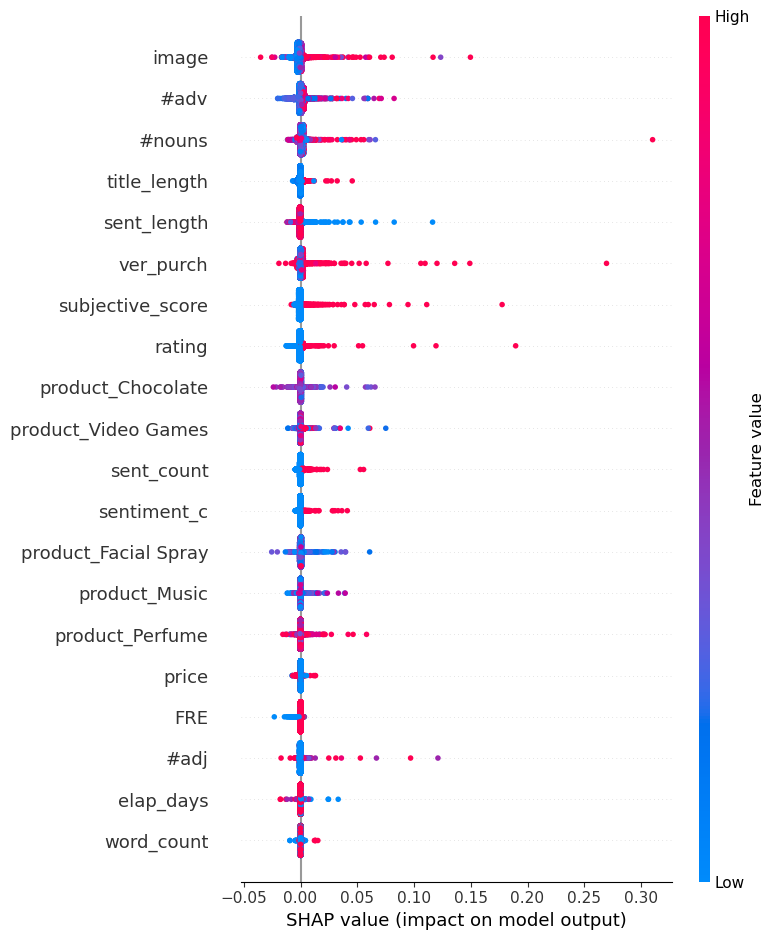

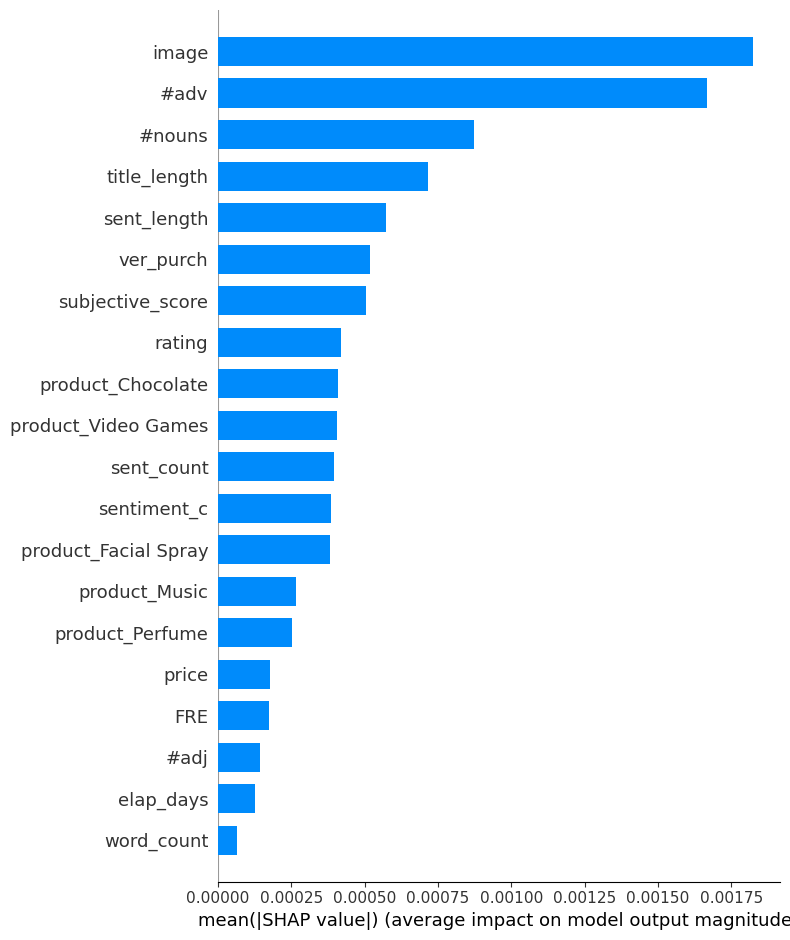

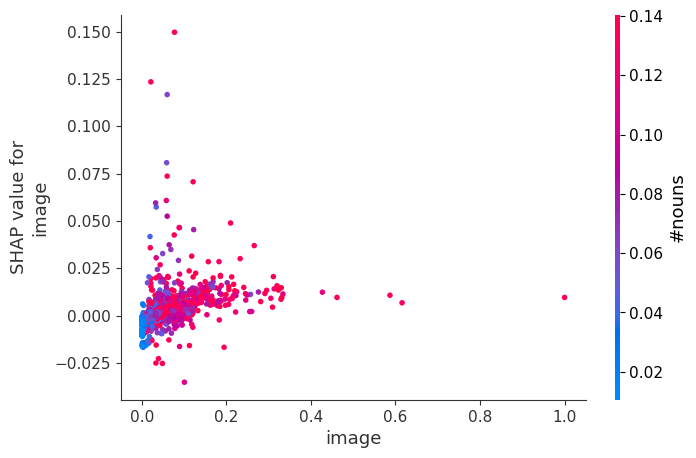

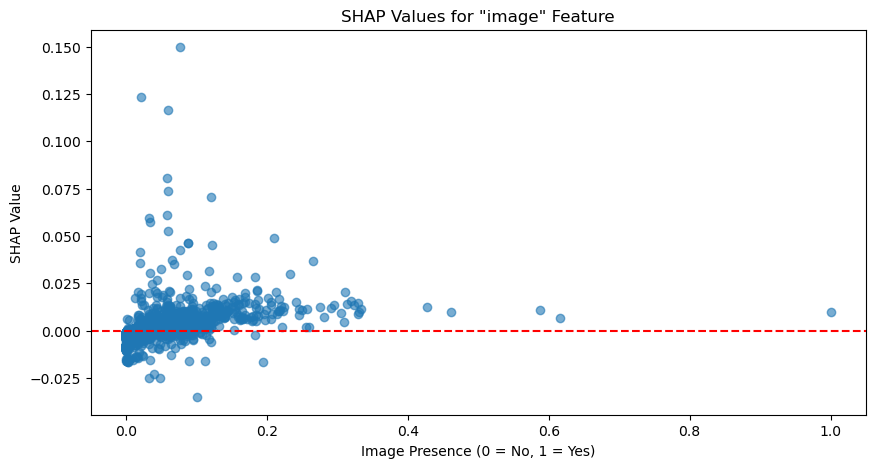

In [14]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_scaled_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled_df)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", show=False)
plt.show()

# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, X_train_scaled_df)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train_scaled_df.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train_scaled_df['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [15]:
# Create the SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the training set
shap_values_train = explainer.shap_values(X_train_scaled_df)


[15:29:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [16]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values_train).mean(axis=0)


In [17]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train_scaled_df.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
8                  image            0.001825
12                  #adv            0.001669
10                #nouns            0.000872
6           title_length            0.000715
5            sent_length            0.000573
9              ver_purch            0.000517
13      subjective_score            0.000505
0                 rating            0.000419
15     product_Chocolate            0.000411
19   product_Video Games            0.000407
4             sent_count            0.000396
2            sentiment_c            0.000386
16  product_Facial Spray            0.000382
17         product_Music            0.000267
18       product_Perfume            0.000251
1                  price            0.000178
14                   FRE            0.000175
11                  #adj            0.000143
7              elap_days            0.000126
3             word_count            0.000064


In [18]:
# Calculate SHAP values for the test set
shap_values_test = explainer.shap_values(X_test_scaled_df)


NameError: name 'X_test_scaled_df' is not defined

In [ ]:
# Loop through each instance in the test set
for example_index in range(len(X_test)):
    # Extract SHAP values for the specific instance
    example_shap_values = shap_values_test[example_index]
    # Extract the corresponding predicted and actual value for the instance
    predicted_value = y_pred_default[example_index]
    actual_value = y_test[example_index]

    # Create a DataFrame for plotting
    shap_values_df = pd.DataFrame({
        'feature': X_test_scaled_df.columns,
        'shap_value': example_shap_values
    })

    # Sort the DataFrame based on the SHAP values
    shap_values_df_sorted = shap_values_df.sort_values(by='shap_value', ascending=True)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(shap_values_df_sorted['feature'], shap_values_df_sorted['shap_value'], color='skyblue')
    plt.xlabel('SHAP Value')
    # Include predicted and actual value in the title
    plt.title(f'SHAP Values for Instance Index {example_index}\nPredicted: {predicted_value:.2f}, Actual: {actual_value[0]:.2f}')
    plt.grid(True)
    plt.show()


In [ ]:
# Train Model with specific hyperparameters
best_hyperparams = {'colsample_bytree': 0.8732354792666625, 'gamma': 0.03613182317974, 'learning_rate': 0.001986697844495, 'max_depth': 1100.0, 'min_child_weight': 5.0, 'n_estimators': 10.0, 'reg_alpha': 0.05550987424359057, 'reg_lambda': 2.469762787227609, 'subsample': 0.6244860331308989}

# Train model
xgb_reg = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda
)

# Training the model
xgb_reg.fit(X_train, y_train)

# Predictions on test data
y_pred = xgb_reg.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("\nModel Evaluation:")
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")